# Analyzing hyperpartisan documents

**Corpus Linguistics**

**Julen Etxaniz**

The purpose of this assignment is to analyze the usage of words in documents which are considered to be *hyperpartisan*, or not. Hyperpartisan arguments are those that "exhibit blind, prejudiced, or unreasoning allegiance to one party, faction, cause, or person".

You will be given two main documents:

- [articles-validation-bypublisher-20181122.xml.zip](https://zenodo.org/record/1489920/files/articles-validation-bypublisher-20181122.zip?download=1) (332 MB): an XML document 150k News articles.

- [ground-truth-validation-bypublisher-20181122.xml.zip](https://zenodo.org/record/1489920/files/ground-truth-validation-bypublisher-20181122.zip?download=1) (5.2MB): a document that states whether the News articles contain hyperartisan ar- guments or not.

The dataset were used in the [semeval-2019 task 4](https://pan.webis.de/semeval19/semeval19-web/) on hyperpartisan News detection. Whereas the task on semeval was to design a system to auto- matically detect hyperpartisan news, in this exercise we are going to exploit both corpora (hyperpartisan and not hyperpartisan news), and analyze which terms are the most relevant in each of the sets. For this, analysis we will use the so-called log odd ratio.

I recommend you to follow a two-step approach to obtain the log-odd ratios of the words. In the rst step, you should generate text les from the XML documents. Then, in a separated step, you should create a le with the words along with its **log-odd ratio**.

In [1]:
%cd /content/drive/MyDrive/LAP/Subjects/CL/assignments/hyperpartisan

/content/drive/MyDrive/LAP/Subjects/CL/assignments/hyperpartisan


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Generate text files

The first step is to generate two text files for hyperpartisan and non-hyperpartisan news articles, respectively. You have to divide the News articles contained in [articles-validation-bypublisher-20181122.xml.zip](https://zenodo.org/record/1489920/files/articles-validation-bypublisher-20181122.zip?download=1) into two text les (`hyperpartisan.txt` and `non-hyperpartisan.txt`), according to their ground truth value in [ground-truth-validation-bypublisher-20181122.xml.zip](https://zenodo.org/record/1489920/files/ground-truth-validation-bypublisher-20181122.zip?download=1). You will need the `lxml` library in python to analyze the XML documents and extract the necessary information.

When dividing the articles, it is highly recommended that you tokenize the text using a proper tokenizer. There are several tokenizers available for English in Python, chose the one that fits you best.

In [3]:
"""Generate two text files for hyperpartisan and non-hyperpartisan
news articles."""
import string
from lxml import etree
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm


PATH = "../../data/hyperpartisan/"
PUNCTUATION = string.punctuation + "‘’“”«»–…•"
STOPWORDS = set(stopwords.words('english'))
ENTITIES = set(["lt", "amp", "gt", "quot", "apos"])
IMAGE = set(["img", "alt", "src", "width", "height", "https", "datarecalcdims", "aligncenter"])


def clean_text(text):
    """Tokenize text, convert words to lowercase, remove puntuation,
    numbers, stop words, xml entities and image tags.

    Args:
        text (str): text to be cleaned

    Returns:
        str: cleaned text
    """
    # split into tokens
    words = word_tokenize(text)
    # convert to lower case and remove punctuation
    table = str.maketrans('', '', PUNCTUATION)
    words = [str.lower(word.translate(table)) for word in words]
    # remove numbers, stop words, xml entities and image tags
    words = [word for word in words if word.isalpha() and word not in STOPWORDS | ENTITIES | IMAGE]
    # join words to string
    text = " ".join(words)
    # remove extra whitespace
    text = " ".join(text.split())
    # strip whitespace at start and end
    text = text.strip()
    return text


def save_text(article_tree, class_dict, hyp_file, non_file):
    """Save text of hyperpartisan and non-hyperpartisan articles.

    Args:
        article_tree (xml.etree.ElementTree): articles xml document tree
        class_dict (dict): dictionary of article ids and their hyperpartisan class
        hyp_file (TextIOWrapper): hyperarpartisan output file
        non_file (TextIOWrapper): non-hyperpartisan output file
    """
    for article in tqdm(article_tree.xpath("/articles/article")):
        ident = article.get("id")
        title = article.get("title")
        title = clean_text(title)
        text = article.xpath("string(.)")
        text = clean_text(text)
        line = f"{title} {text}".strip()
        if class_dict[ident] == "true":
            hyp_file.write(f"{line}\n")
        else:
            non_file.write(f"{line}\n")


def get_class_dict(class_tree):
    """Get dictionary of article ids and their hyperpartisan class.

    Args:
        class_tree (xml.etree.ElementTree): class xml document tree

    Returns:
        dict: dictionary of article ids and their hyperpartisan class
    """
    class_dict = {}
    for article in class_tree.xpath("/articles/article"):
        class_dict[article.get("id")] = article.get("hyperpartisan")
    return class_dict


def generate_text_files():
    """Main function that generates hyperpartisan and non-hyperpartisan text files."""
    # discard whitespace nodes
    parser = etree.XMLParser(remove_blank_text=True)

    # parse article document
    article_tree = etree.parse(
        f"{PATH}articles-validation-bypublisher-20181122.xml", parser)

    # parse class document
    class_tree = etree.parse(
        f"{PATH}ground-truth-validation-bypublisher-20181122.xml", parser)

    class_dict = get_class_dict(class_tree)

    with open(f"{PATH}hyperpartisan.txt", 'w', encoding="utf-8") as hyp_file, \
            open(f"{PATH}non-hyperpartisan.txt", 'w', encoding="utf-8") as non_file:
        save_text(article_tree, class_dict, hyp_file, non_file)

In [4]:
generate_text_files()

100%|██████████| 150000/150000 [26:15<00:00, 95.20it/s]


## 2. Extract log-odd ratios

Having the two text files, write a script that extracts the log-odd ratios of each word, by applying the equations. Because the log-odd ratio is sensitive to infrequent words, discard words that appear less than 20 times in the corpus. As a bonus, you can also extract the log-odd ratios of the bigrams in the corpus.

The log odd ratio is a measure of words compared on two sets of documents ($i$ and $j$), which in our case corresponds to hyperpartisan and non-hyperpartisan documents, respectively. Each word then can be associated with its log-odd ratio $r_w$, which is a number that can be positive or negative: positive numbers are associated with set $i$, and negative numbers with set $j$.

The log-odd ratio $r_w$ is defined as:

$$p_w^{(i)} = \frac{f_w^{(i)}}{N^{(i)}}; p_w^{(j)} = \frac{f_w^{(j)}}{N^{(j)}}$$

$$o_w^{(i)} = \frac{p_w^{(i)}}{1-p_w^{(i)}}; o_w^{(j)} = \frac{p_w^{(j)}}{1-p_w^{(j)}}$$

$$r_w = \log{o_w^{(i)}} - \log{o_w^{(j)}}$$

where $f_w^{(i)}$ is the frequency of word $w$ in group $i$ (hyperpartisan or non-hyperpartisan), and $N^{(i)}$ is the number of words in group $i$.

For example, suppose that the word $gold$ appears $2,500$ times on hyperpartisan documents ($f_{gold}^{(i)} = 2500$), and $760$ times on non-hyperpartisan documents ($f_{gold}^{(j)} = 760$). Furthermore, suppose that there are $25,000$ words in hyperpartisan documents ($N^{i} = 25000$), and $17,500$ on non-hyperpartisan documents ($N^{j} = 17000$). Then:

$$p_{gold}^{(i)} = \frac{2500}{25000} = 0.1; p_{gold}^{(j)} = \frac{760}{17500} = 0.045$$

$$o_{gold}^{(i)} = \frac{0.1}{1-0.1} = 0.11; o_{gold}^{(j)} = \frac{0.045}{1-0.045} = 0.047$$

$$r_{gold} = \log{0.11} - \log{0.047} = 0.369$$

and therefore the log odd ratio of $gold$ is $0.369$.

In [5]:
"""Extracts log odds ratios for words and bigrams."""
from collections import defaultdict
from math import log
from tqdm import tqdm

PATH = "../../data/hyperpartisan/"


def word_bigram_freq(filename):
    """Return two dictionaries with the word and bigram frequencies in a file.

    Args:
        filename (str): path to file

    Returns:
        defaultdict[str, int]: dictionary with word frequencies
        defaultdict[str, int]: dictionary with bigram frequencies
    """
    word_freq = defaultdict(int)
    bigram_freq = defaultdict(int)
    with open(filename, encoding='utf-8') as file:
        for line in tqdm(file.readlines()):
            words = line.split()
            for i in range(len(words) - 1):
                word_freq[words[i]] += 1
                bigram_freq[f"{words[i]}\t{words[i+1]}"] += 1
            word_freq[words[len(words) - 1]] += 1
    return word_freq, bigram_freq


def log_odd(freq, total):
    """Return the log odds for a word or bigram.

    Args:
        freq (int): word frequency
        total (int): total number of words or bigrams

    Returns:
        float: log odd for the word or bigram
    """
    prob = freq / total
    odd = prob / (1 - prob)
    return log(odd)


def log_odd_ratio(string_freq_hyp, string_freq_non, min_freq=20):
    """Return the log odd ratios for words or bigrams.

    Args:
        string_freq_hyp (defaultdict[str, int]): dictionary with word or bigram frequencies
            in hyperpartisan file
        string_freq_non (defaultdict[str, int]): dictionary with word or bigram frequencies
            in non-hyperpartisan file
        min_freq (int): minimum frequency for a word or bigram to be included

    Returns:
        defaultdict[str, float]: log odds ratios for each word or bigram
    """
    n_hyp = sum(string_freq_hyp.values())
    n_non = sum(string_freq_non.values())
    log_odds = defaultdict(float)
    strings = set(string_freq_hyp.keys())
    strings.update(string_freq_non.keys())
    for string in tqdm(strings):
        freq_hyp = string_freq_hyp[string]
        freq_non = string_freq_non[string]
        if freq_hyp < min_freq or freq_non < min_freq:
            continue
        log_odds[string] = log_odd(freq_hyp, n_hyp) - log_odd(freq_non, n_non)
    return log_odds


def write_results(log_odds, hyp_out, non_out, count=50):
    """Write the results to hyperpartisan and non-hyperpartisan files.

    Args:
        log_odds (defaultdict[str, float]): dictionary with log odds ratios
        hyp_out (file): file to write hyperpartisan results to
        non_out (file): file to write non-hyperpartisan results to
        count (int): number of results to write to each file
    """
    sorted_log_odds = sorted(
        log_odds.items(), key=lambda x: x[1], reverse=True)

    with open(hyp_out, "w", encoding="utf-8") as file:
        for string, odd in sorted_log_odds[:count]:
            file.write(f"{string}\t{odd}\n")

    with open(non_out, "w", encoding="utf-8") as file:
        for string, odd in sorted_log_odds[::-1][:count]:
            file.write(f"{string}\t{odd}\n")


def extract_log_odd_ratios():
    """Main function that extracts log odds ratios for words and bigrams."""
    hyp_inp = f"{PATH}hyperpartisan.txt"
    non_inp = f"{PATH}non-hyperpartisan.txt"
    word_freq_hyp, bigram_freq_hyp = word_bigram_freq(hyp_inp)
    word_freq_non, bigram_freq_non = word_bigram_freq(non_inp)

    log_odd_words = log_odd_ratio(word_freq_hyp, word_freq_non)
    hyp_words = "hyperpartisan_words.tsv"
    non_words = "non-hyperpartisan_words.tsv"
    write_results(log_odd_words, hyp_words, non_words)

    log_odd_bigrams = log_odd_ratio(bigram_freq_hyp, bigram_freq_non)
    hyp_bigrams = "hyperpartisan_bigrams.tsv"
    non_bigrams = "non-hyperpartisan_bigrams.tsv"
    write_results(log_odd_bigrams, hyp_bigrams, non_bigrams)

In [6]:
extract_log_odd_ratios()

100%|██████████| 20925996/20925996 [00:42<00:00, 495757.36it/s]


## 3. Analyze the results

Having the log-odd ratios, extract the most relevant 50 words in hyperpartisan and non-hyperpartisan documents. Analyze these words, and write a small document with your ndings. Is there any interesting word on some set? Can you draw some conclusions regarding hyperpartisan text with respect to non-hyperpartisan ones? If you also computed the log-odd ratios for bigrams, repeat the analysis using bigrams.

### Words

In [29]:
import pandas as pd

hyp_words = "hyperpartisan_words.tsv"
non_words = "non-hyperpartisan_words.tsv"
df_hyp_words = pd.read_csv(hyp_words, delimiter="\t", header=None, names=["word_hyp", "ratio_hyp"])
df_non_words = pd.read_csv(non_words, delimiter="\t", header=None, names=["word_non", "ratio_non"])

df_words = pd.concat([df_hyp_words, df_non_words], axis=1)
df_words

,word_hyp,ratio_hyp,word_non,ratio_non
0,wonkette,4.766308,subsaharan,-4.048749
1,vulgarity,4.173284,straus,-3.764541
2,realclearpolitics,3.829906,treasuries,-3.724858
3,newsbusters,3.771831,zuma,-3.620416
4,oreilly,3.748927,boko,-3.496393
5,profanity,3.475565,tic,-3.489986
6,kilmeade,3.455017,renminbi,-3.444235
7,vox,3.436602,haram,-3.435708
8,chomsky,3.379043,bangkok,-3.418287
9,courteous,3.355654,checker,-3.412333


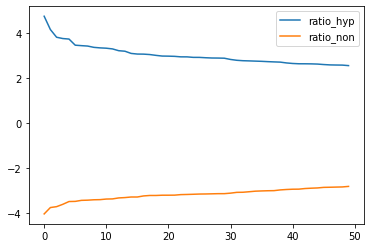

In [30]:
df_words.plot()

### Bigrams

In [32]:
hyp_bigrams = "hyperpartisan_bigrams.tsv"
non_bigrams = "non-hyperpartisan_bigrams.tsv"
df_hyp_bigrams = pd.read_csv(hyp_bigrams, delimiter="\t", header=None, names=["word1_hyp", "word2_hyp", "ratio_hyp"])
df_non_bigrams = pd.read_csv(non_bigrams, delimiter="\t", header=None, names=["word1_non", "word2_non", "ratio_non"])

df_bigrams = pd.concat([df_hyp_bigrams, df_non_bigrams], axis=1)
df_bigrams

,word1_hyp,word2_hyp,ratio_hyp,word1_non,word2_non,ratio_non
0,repeat,offenders,4.161542,texas,tribune,-5.507141
1,state,shall,4.075875,may,subject,-4.207894
2,media,keep,3.985353,emerging,economies,-4.049838
3,reserve,right,3.827898,complete,list,-3.859180
4,media,research,3.681539,exchange,rate,-3.657217
5,trump,nt,3.596004,us,assets,-3.656429
6,white,privilege,3.556554,texas,house,-3.611152
7,illegal,alien,3.476798,boko,haram,-3.555604
8,like,college,3.454393,emerging,markets,-3.496783
9,law,shall,3.446732,dan,patrick,-3.472826


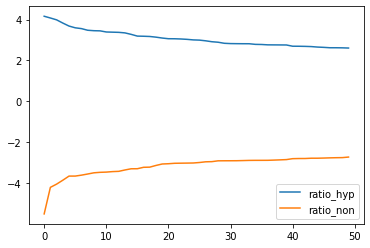

In [33]:
df_bigrams.plot()